In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

import utils.data_processing_bronze_table
import utils.data_processing_silver_table
import utils.data_processing_gold_table


## set up pyspark session

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/30 09:48:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## set up config

In [3]:
# set up config
snapshot_date_str = "2023-01-01"

start_date_str = "2023-01-01"
#end_date_str = "2023-01-01"
end_date_str = "2024-12-01"

In [4]:
# generate list of dates to process
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)

    while current_date <= end_date:
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date.strftime("%Y-%m-%d"))
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return first_of_month_dates

dates_str_lst = generate_first_of_month_dates(start_date_str, end_date_str)
dates_str_lst

['2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01',
 '2024-04-01',
 '2024-05-01',
 '2024-06-01',
 '2024-07-01',
 '2024-08-01',
 '2024-09-01',
 '2024-10-01',
 '2024-11-01',
 '2024-12-01']

## Build Bronze Table

In [5]:
# create bronze datalake
bronze_lms_directory = "datamart/bronze/lms/"
bronze_clickstream_directory = "datamart/bronze/users/clickstream/"
bronze_attributes_directory = "datamart/bronze/users/attributes/"
bronze_financials_directory = "datamart/bronze/users/financials/"

if not os.path.exists(bronze_lms_directory):
    os.makedirs(bronze_lms_directory)

if not os.path.exists(bronze_clickstream_directory):
    os.makedirs(bronze_clickstream_directory)

if not os.path.exists(bronze_attributes_directory):
    os.makedirs(bronze_attributes_directory)

if not os.path.exists(bronze_financials_directory):
    os.makedirs(bronze_financials_directory)

In [6]:
# run bronze backfill
for date_str in dates_str_lst:
    utils.data_processing_bronze_table.process_bronze_loans(date_str, bronze_lms_directory, spark)
    utils.data_processing_bronze_table.process_bronze_users(date_str, bronze_clickstream_directory, bronze_attributes_directory, bronze_financials_directory, spark)

2023-01-01 row count: 530
saved to: datamart/bronze/lms/bronze_loan_daily_2023_01_01.csv
2023-01-01 row count (clickstream): 8974
saved to: datamart/bronze/users/clickstream/bronze_users_clickstream_2023_01_01.csv
2023-01-01 row count (attributes): 530
saved to: datamart/bronze/users/attributes/bronze_users_attributes_2023_01_01.csv
2023-01-01 row count (financials): 530
saved to: datamart/bronze/users/financials/bronze_users_financials_2023_01_01.csv
2023-02-01 row count: 1031
saved to: datamart/bronze/lms/bronze_loan_daily_2023_02_01.csv
2023-02-01 row count (clickstream): 8974
saved to: datamart/bronze/users/clickstream/bronze_users_clickstream_2023_02_01.csv
2023-02-01 row count (attributes): 501
saved to: datamart/bronze/users/attributes/bronze_users_attributes_2023_02_01.csv
2023-02-01 row count (financials): 501
saved to: datamart/bronze/users/financials/bronze_users_financials_2023_02_01.csv
2023-03-01 row count: 1537
saved to: datamart/bronze/lms/bronze_loan_daily_2023_03_01.c

In [7]:
# inspect output
loans_df = utils.data_processing_bronze_table.process_bronze_loans(date_str, bronze_lms_directory, spark)
click_df, attr_df, fin_df = utils.data_processing_bronze_table.process_bronze_users(date_str, bronze_clickstream_directory, 
                                                                                    bronze_attributes_directory, bronze_financials_directory, 
                                                                                    spark)

2024-12-01 row count: 5531
saved to: datamart/bronze/lms/bronze_loan_daily_2024_12_01.csv
2024-12-01 row count (clickstream): 8974
saved to: datamart/bronze/users/clickstream/bronze_users_clickstream_2024_12_01.csv
2024-12-01 row count (attributes): 515
saved to: datamart/bronze/users/attributes/bronze_users_attributes_2024_12_01.csv
2024-12-01 row count (financials): 515
saved to: datamart/bronze/users/financials/bronze_users_financials_2024_12_01.csv


In [8]:
loans_df.limit(5).toPandas()

,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date
0,CUS_0x100b_2024_03_01,CUS_0x100b,2024-03-01,10,9,10000,1000.0,1000.0,0.0,1000.0,2024-12-01
1,CUS_0x102e_2024_04_01,CUS_0x102e,2024-04-01,10,8,10000,1000.0,0.0,6000.0,8000.0,2024-12-01
2,CUS_0x1038_2024_10_01,CUS_0x1038,2024-10-01,10,2,10000,1000.0,1000.0,0.0,8000.0,2024-12-01
3,CUS_0x103e_2024_12_01,CUS_0x103e,2024-12-01,10,0,10000,0.0,0.0,0.0,10000.0,2024-12-01
4,CUS_0x1048_2024_02_01,CUS_0x1048,2024-02-01,10,10,10000,1000.0,0.0,9000.0,9000.0,2024-12-01


In [9]:
loans_df.dtypes

[('loan_id', 'string'),
 ('Customer_ID', 'string'),
 ('loan_start_date', 'date'),
 ('tenure', 'int'),
 ('installment_num', 'int'),
 ('loan_amt', 'int'),
 ('due_amt', 'double'),
 ('paid_amt', 'double'),
 ('overdue_amt', 'double'),
 ('balance', 'double'),
 ('snapshot_date', 'date')]

In [10]:
click_df.limit(5).toPandas()

,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,145,189,109,134,196,-37,101,82,111,24,...,65,249,200,185,-83,-18,-76,30,CUS_0x1037,2024-12-01
1,40,184,187,75,192,146,38,109,353,141,...,-14,193,125,117,215,91,33,255,CUS_0x1069,2024-12-01
2,98,121,180,200,95,48,59,194,76,84,...,167,101,92,185,98,68,-60,116,CUS_0x114a,2024-12-01
3,85,96,19,47,30,39,-32,210,-81,206,...,143,94,139,237,78,187,77,33,CUS_0x1184,2024-12-01
4,98,45,155,56,112,47,52,138,153,225,...,-43,142,121,10,189,110,264,241,CUS_0x1297,2024-12-01


In [11]:
click_df.dtypes

[('fe_1', 'int'),
 ('fe_2', 'int'),
 ('fe_3', 'int'),
 ('fe_4', 'int'),
 ('fe_5', 'int'),
 ('fe_6', 'int'),
 ('fe_7', 'int'),
 ('fe_8', 'int'),
 ('fe_9', 'int'),
 ('fe_10', 'int'),
 ('fe_11', 'int'),
 ('fe_12', 'int'),
 ('fe_13', 'int'),
 ('fe_14', 'int'),
 ('fe_15', 'int'),
 ('fe_16', 'int'),
 ('fe_17', 'int'),
 ('fe_18', 'int'),
 ('fe_19', 'int'),
 ('fe_20', 'int'),
 ('Customer_ID', 'string'),
 ('snapshot_date', 'date')]

In [12]:
attr_df.limit(5).toPandas()

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date
0,CUS_0x103e,Tim Kellyf,40,155-72-8070,Scientist,2024-12-01
1,CUS_0x1195,Alexk,31,822-48-3629,Manager,2024-12-01
2,CUS_0x1197,Nayako,28,799-23-8283,_______,2024-12-01
3,CUS_0x11e2,Valetkevitchr,34,809-04-1419,Musician,2024-12-01
4,CUS_0x11ec,William Schombergh,34,417-74-2163,Journalist,2024-12-01


In [13]:
fin_df.limit(5).toPandas()

,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date
0,CUS_0x103e,98690.8,8262.233333,4,6,9,1_,Student Loan,6,17,...,Good,706.96,26.860663,26 Years and 11 Months,No,55.004408,913.4813186573292,Low_spent_Small_value_payments,147.7376071067124,2024-12-01
1,CUS_0x1195,30429.91,2808.825833,4,6,16,2,"Auto Loan, and Auto Loan",22,17,...,Standard,362.48,33.349050,28 Years and 11 Months,No,29.914076,82.87878577514347,Low_spent_Large_value_payments,438.08972109416084,2024-12-01
2,CUS_0x1197,92300.01,7437.667500,2,4,11,3,"Credit-Builder Loan, Not Specified, and Credit...",27,9,...,_,755.17_,26.989787,18 Years and 11 Months,Yes,49236.000000,220.8621525417414,Low_spent_Large_value_payments,581.1567885447394,2024-12-01
3,CUS_0x11e2,44986.55,3689.879167,6,5,11,1,Credit-Builder Loan,0,4,...,Good,753.21,25.586286,20 Years and 0 Months,No,23.267135,43.20363344633164,High_spent_Large_value_payments,542.5171477430948,2024-12-01
4,CUS_0x11ec,14867.69,1005.974167,9,9,18,6,"Debt Consolidation Loan, Student Loan, Persona...",39,15,...,Standard,2344.06,24.344388,17 Years and 2 Months,Yes,55.459604,100.14574834721886,Low_spent_Medium_value_payments,224.99206407779144,2024-12-01


In [14]:
fin_df.dtypes

[('Customer_ID', 'string'),
 ('Annual_Income', 'string'),
 ('Monthly_Inhand_Salary', 'double'),
 ('Num_Bank_Accounts', 'int'),
 ('Num_Credit_Card', 'int'),
 ('Interest_Rate', 'int'),
 ('Num_of_Loan', 'string'),
 ('Type_of_Loan', 'string'),
 ('Delay_from_due_date', 'int'),
 ('Num_of_Delayed_Payment', 'string'),
 ('Changed_Credit_Limit', 'string'),
 ('Num_Credit_Inquiries', 'double'),
 ('Credit_Mix', 'string'),
 ('Outstanding_Debt', 'string'),
 ('Credit_Utilization_Ratio', 'double'),
 ('Credit_History_Age', 'string'),
 ('Payment_of_Min_Amount', 'string'),
 ('Total_EMI_per_month', 'double'),
 ('Amount_invested_monthly', 'string'),
 ('Payment_Behaviour', 'string'),
 ('Monthly_Balance', 'string'),
 ('snapshot_date', 'date')]

## EDA on user clickstream feature

In [15]:
df = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv(os.path.join(bronze_clickstream_directory, "*.csv")))

click_pdf = df.toPandas()

### Check duplicated customer id with same snapshot date

In [16]:
print(click_pdf.duplicated(['Customer_ID']).sum())

206402


### Check missing values

In [17]:
print(click_pdf.isnull().sum())

fe_1             0
fe_2             0
fe_3             0
fe_4             0
fe_5             0
fe_6             0
fe_7             0
fe_8             0
fe_9             0
fe_10            0
fe_11            0
fe_12            0
fe_13            0
fe_14            0
fe_15            0
fe_16            0
fe_17            0
fe_18            0
fe_19            0
fe_20            0
Customer_ID      0
snapshot_date    0
dtype: int64


## EDA on user attributes feature

In [18]:
df = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv(os.path.join(bronze_attributes_directory, "*.csv")))

attr_pdf = df.toPandas()

### Check duplicated customer id with same snapshot date

In [19]:
print(attr_pdf.duplicated(['Customer_ID']).sum())

0


### Check missing values

In [20]:
print(attr_pdf.isnull().sum())

Customer_ID      0
Name             0
Age              0
SSN              0
Occupation       0
snapshot_date    0
dtype: int64


In [21]:
attr_pdf.describe(include='all')

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date
count,11974,11974,11974,11974,11974,11974
unique,11974,9777,291,11299,16,24
top,CUS_0xfe4,Langep,32,#F%$D@*&8,_______,2024-08-01
freq,1,6,344,676,846,543


### Check unique string that may require cleansing and standardize

In [22]:
print(attr_pdf['Name'].unique())
print(attr_pdf['Age'].unique())
print(attr_pdf['SSN'].unique())
print(attr_pdf['Occupation'].unique())

['Zhouy' 'Moony' 'Blenkinsopr' ... 'Olaoyes' 'Mirwaisd' 'Sarah McBriden']
['29' '24' '26_' '48' '5656' '34_' '30' '40' '32' '15' '46' '52' '20' '27'
 '39' '35' '33' '41' '28' '23' '26' '54' '56' '44' '27_' '34' '16' '50_'
 '40_' '45_' '32_' '53' '22_' '25' '31' '45' '37' '21' '42' '49' '38' '18'
 '3640' '22' '19' '17' '30_' '55' '1388' '24_' '36' '29_' '43' '51' '-500'
 '47' '2672' '21_' '51_' '41_' '8125' '3441' '50' '2598' '16_' '28_'
 '3856' '38_' '8467' '2329_' '8100' '39_' '18_' '6283' '15_' '31_' '42_'
 '23_' '48_' '8547' '1094' '8448' '43_' '2038' '203' '14' '35_' '2604'
 '7459' '37_' '1814' '3834_' '54_' '19_' '36_' '52_' '4670' '2778' '25_'
 '506' '4431' '395' '3052' '5784' '47_' '53_' '5498' '2160' '33_' '448'
 '6043' '17_' '4536' '4049' '1265' '509' '4746' '5959' '2318' '6280' '44_'
 '5645' '4351' '6728' '4909' '7279' '46_' '55_' '8628' '6657' '344' '6113'
 '20_' '1990' '3493' '4120' '7139' '7123' '325' '56_' '8199' '6849' '6991'
 '8216' '4458' '8442' '4391' '3513' '7342' '5

## EDA on user financials feature

In [23]:
df = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv(os.path.join(bronze_financials_directory, "*.csv")))

fin_pdf = df.toPandas()

### Check duplicated customer id with same snapshot date

In [24]:
print(fin_pdf.duplicated(['Customer_ID']).sum())

0


### Check missing values

In [25]:
print(fin_pdf.isnull().sum())

Customer_ID                    0
Annual_Income                  0
Monthly_Inhand_Salary          0
Num_Bank_Accounts              0
Num_Credit_Card                0
Interest_Rate                  0
Num_of_Loan                    0
Type_of_Loan                1368
Delay_from_due_date            0
Num_of_Delayed_Payment         0
Changed_Credit_Limit           0
Num_Credit_Inquiries           0
Credit_Mix                     0
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Credit_History_Age             0
Payment_of_Min_Amount          0
Total_EMI_per_month            0
Amount_invested_monthly        0
Payment_Behaviour              0
Monthly_Balance                0
snapshot_date                  0
dtype: int64


### Check unique string that may require cleansing and standardize

In [26]:
fin_pdf.describe(include='object')

,Customer_ID,Annual_Income,Num_of_Loan,Type_of_Loan,Num_of_Delayed_Payment,Changed_Credit_Limit,Credit_Mix,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date
count,11974,11974,11974,10606,11974,11974,11974,11974,11974,11974,11974,11974,11974,11974
unique,11974,11967,85,6016,166,2962,4,11713,392,3,11414,7,11974,24
top,CUS_0xff6,17273.83,3,Not Specified,19,_,Standard,1360.45,19 Years and 9 Months,Yes,__10000__,Low_spent_Small_value_payments,592.0056861539196,2024-08-01
freq,1,2,1731,170,711,246,4287,3,76,6291,540,3064,1,543


In [27]:
def uniques_not_float_pd(s: pd.Series):
    mask_nonempty = s.astype("string").str.strip().notna() & (s.astype("string").str.strip() != "")
    as_float = pd.to_numeric(s, errors="coerce")
    return s[mask_nonempty & as_float.isna()].unique()

In [28]:
print("Annual_Income:",
      uniques_not_float_pd(fin_pdf['Annual_Income'])[:5])

print("Num_of_Loan:",
      uniques_not_float_pd(fin_pdf['Num_of_Loan'])[:5])

print("Type_of_Loan:",
      fin_pdf['Type_of_Loan'].unique())

print("Num_of_Delayed_Payment:",
      uniques_not_float_pd(fin_pdf['Num_of_Delayed_Payment'])[:5])

print("Changed_Credit_Limit:",
      uniques_not_float_pd(fin_pdf['Changed_Credit_Limit'])[:5])

print("Credit_Mix",
      fin_pdf['Credit_Mix'].unique())

print("Outstanding_Debt:",
      uniques_not_float_pd(fin_pdf['Outstanding_Debt'])[:5])

print("Credit_History_Age:",
      fin_pdf['Credit_History_Age'].unique())

print("Payment_of_Min_Amount:",
      fin_pdf['Payment_of_Min_Amount'].unique())

print("Amount_invested_monthly:",
      uniques_not_float_pd(fin_pdf['Amount_invested_monthly'])[:5])

print("Payment_Behaviour:",
      fin_pdf['Payment_Behaviour'].unique())

print("Monthly_Balance:",
      uniques_not_float_pd(fin_pdf['Monthly_Balance'])[:5])


Annual_Income: ['32370.6_' '33410.45_' '40019.0_' '18811.58_' '18753.34_']
Num_of_Loan: ['3_' '4_' '5_' '2_' '6_']
Type_of_Loan: ['Credit-Builder Loan, Credit-Builder Loan, Home Equity Loan, and Debt Consolidation Loan'
 'Payday Loan'
 'Student Loan, Payday Loan, Not Specified, Mortgage Loan, Home Equity Loan, Payday Loan, Payday Loan, Not Specified, and Credit-Builder Loan'
 ...
 'Credit-Builder Loan, Not Specified, Credit-Builder Loan, Mortgage Loan, Credit-Builder Loan, Debt Consolidation Loan, and Home Equity Loan'
 'Auto Loan, Personal Loan, Student Loan, Personal Loan, Auto Loan, Auto Loan, and Credit-Builder Loan'
 'Debt Consolidation Loan, Home Equity Loan, Personal Loan, Debt Consolidation Loan, Payday Loan, Mortgage Loan, and Auto Loan']
Num_of_Delayed_Payment: ['12_' '20_' '13_' '3_' '4_']
Changed_Credit_Limit: ['_']
Credit_Mix ['_' 'Good' 'Bad' 'Standard']
Outstanding_Debt: ['30.31_' '127.88_' '270.42_' '758.45_' '422.57_']
Credit_History_Age: ['16 Years and 3 Months' '30 Y

## Build Silver Table

In [29]:
# create bronze datalake
silver_loan_daily_directory = "datamart/silver/loan_daily/"
silver_clickstream_directory = "datamart/silver/users/clickstream/"
silver_attributes_directory = "datamart/silver/users/attributes/"
silver_financials_directory = "datamart/silver/users/financials/"

if not os.path.exists(silver_loan_daily_directory):
    os.makedirs(silver_loan_daily_directory)
    
if not os.path.exists(silver_clickstream_directory):
    os.makedirs(silver_clickstream_directory)

if not os.path.exists(silver_attributes_directory):
    os.makedirs(silver_attributes_directory)

if not os.path.exists(silver_financials_directory):
    os.makedirs(silver_financials_directory)

In [30]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_table.process_silver_loans(date_str, bronze_lms_directory, silver_loan_daily_directory, spark)
    utils.data_processing_silver_table.process_silver_users(date_str, bronze_clickstream_directory, bronze_attributes_directory, \
                                                            bronze_financials_directory, silver_clickstream_directory, \
                                                            silver_attributes_directory, silver_financials_directory, spark)


loaded from: datamart/bronze/lms/bronze_loan_daily_2023_01_01.csv row count: 530


saved to: datamart/silver/loan_daily/silver_loan_daily_2023_01_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2023_01_01.csv row count: 530
saved to: datamart/silver/users/attributes/silver_users_attributes_2023_01_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2023_01_01.csv row count: 8974


saved to: datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2023_01_01.csv row count: 530


saved to: datamart/silver/users/financials/silver_users_financials_2023_01_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_02_01.csv row count: 1031
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_02_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2023_02_01.csv row count: 501
saved to: datamart/silver/users/attributes/silver_users_attributes_2023_02_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2023_02_01.csv row count: 8974


saved to: datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2023_02_01.csv row count: 501
saved to: datamart/silver/users/financials/silver_users_financials_2023_02_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_03_01.csv row count: 1537
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_03_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2023_03_01.csv row count: 506
saved to: datamart/silver/users/attributes/silver_users_attributes_2023_03_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2023_03_01.csv row count: 8974
saved to: datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2023_03_01.csv row count: 506
saved to: datamart/silver/users/financials/silver_users_financials_2023_03_01.parquet
loaded 

saved to: datamart/silver/users/financials/silver_users_financials_2023_04_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_05_01.csv row count: 2568
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_05_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2023_05_01.csv row count: 521
saved to: datamart/silver/users/attributes/silver_users_attributes_2023_05_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2023_05_01.csv row count: 8974
saved to: datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2023_05_01.csv row count: 521
saved to: datamart/silver/users/financials/silver_users_financials_2023_05_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_06_01.csv row count: 3085
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_06_01.parquet
loaded from: datamart/bronze/users/attr

saved to: datamart/silver/users/attributes/silver_users_attributes_2023_08_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2023_08_01.csv row count: 8974


saved to: datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2023_08_01.csv row count: 481
saved to: datamart/silver/users/financials/silver_users_financials_2023_08_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_09_01.csv row count: 4491
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_09_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2023_09_01.csv row count: 454
saved to: datamart/silver/users/attributes/silver_users_attributes_2023_09_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2023_09_01.csv row count: 8974
saved to: datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2023_09_01.csv row count: 454
saved to: datamart/silver/users/financials/silver_users_financials_2023_09_01.parquet
loaded 

saved to: datamart/silver/users/attributes/silver_users_attributes_2023_11_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2023_11_01.csv row count: 8974


saved to: datamart/silver/users/clickstream/silver_users_clickstream_2023_11_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2023_11_01.csv row count: 491
saved to: datamart/silver/users/financials/silver_users_financials_2023_11_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_12_01.csv row count: 5428


saved to: datamart/silver/loan_daily/silver_loan_daily_2023_12_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2023_12_01.csv row count: 489
saved to: datamart/silver/users/attributes/silver_users_attributes_2023_12_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2023_12_01.csv row count: 8974
saved to: datamart/silver/users/clickstream/silver_users_clickstream_2023_12_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2023_12_01.csv row count: 489
saved to: datamart/silver/users/financials/silver_users_financials_2023_12_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_01_01.csv row count: 5412
saved to: datamart/silver/loan_daily/silver_loan_daily_2024_01_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2024_01_01.csv row count: 485
saved to: datamart/silver/users/attributes/silver_users_attributes_2024_01_01.parquet
loaded from: datamart

saved to: datamart/silver/users/clickstream/silver_users_clickstream_2024_02_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_02_01.csv row count: 518


saved to: datamart/silver/users/financials/silver_users_financials_2024_02_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_03_01.csv row count: 5425
saved to: datamart/silver/loan_daily/silver_loan_daily_2024_03_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2024_03_01.csv row count: 511
saved to: datamart/silver/users/attributes/silver_users_attributes_2024_03_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2024_03_01.csv row count: 8974
saved to: datamart/silver/users/clickstream/silver_users_clickstream_2024_03_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_03_01.csv row count: 511
saved to: datamart/silver/users/financials/silver_users_financials_2024_03_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_04_01.csv row count: 5417


saved to: datamart/silver/loan_daily/silver_loan_daily_2024_04_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2024_04_01.csv row count: 513
saved to: datamart/silver/users/attributes/silver_users_attributes_2024_04_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2024_04_01.csv row count: 8974
saved to: datamart/silver/users/clickstream/silver_users_clickstream_2024_04_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_04_01.csv row count: 513
saved to: datamart/silver/users/financials/silver_users_financials_2024_04_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_05_01.csv row count: 5391
saved to: datamart/silver/loan_daily/silver_loan_daily_2024_05_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2024_05_01.csv row count: 491
saved to: datamart/silver/users/attributes/silver_users_attributes_2024_05_01.parquet
loaded from: datamart

saved to: datamart/silver/users/clickstream/silver_users_clickstream_2024_06_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_06_01.csv row count: 498


saved to: datamart/silver/users/financials/silver_users_financials_2024_06_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_07_01.csv row count: 5442
saved to: datamart/silver/loan_daily/silver_loan_daily_2024_07_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2024_07_01.csv row count: 505


saved to: datamart/silver/users/attributes/silver_users_attributes_2024_07_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2024_07_01.csv row count: 8974


saved to: datamart/silver/users/clickstream/silver_users_clickstream_2024_07_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_07_01.csv row count: 505
saved to: datamart/silver/users/financials/silver_users_financials_2024_07_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_08_01.csv row count: 5531
saved to: datamart/silver/loan_daily/silver_loan_daily_2024_08_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2024_08_01.csv row count: 543
saved to: datamart/silver/users/attributes/silver_users_attributes_2024_08_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2024_08_01.csv row count: 8974


saved to: datamart/silver/users/clickstream/silver_users_clickstream_2024_08_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_08_01.csv row count: 543


saved to: datamart/silver/users/financials/silver_users_financials_2024_08_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_09_01.csv row count: 5537
saved to: datamart/silver/loan_daily/silver_loan_daily_2024_09_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2024_09_01.csv row count: 493
saved to: datamart/silver/users/attributes/silver_users_attributes_2024_09_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2024_09_01.csv row count: 8974
saved to: datamart/silver/users/clickstream/silver_users_clickstream_2024_09_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_09_01.csv row count: 493
saved to: datamart/silver/users/financials/silver_users_financials_2024_09_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_10_01.csv row count: 5502


saved to: datamart/silver/loan_daily/silver_loan_daily_2024_10_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2024_10_01.csv row count: 456


saved to: datamart/silver/users/attributes/silver_users_attributes_2024_10_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2024_10_01.csv row count: 8974


saved to: datamart/silver/users/clickstream/silver_users_clickstream_2024_10_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_10_01.csv row count: 456
saved to: datamart/silver/users/financials/silver_users_financials_2024_10_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_11_01.csv row count: 5501


saved to: datamart/silver/loan_daily/silver_loan_daily_2024_11_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2024_11_01.csv row count: 488


saved to: datamart/silver/users/attributes/silver_users_attributes_2024_11_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2024_11_01.csv row count: 8974
saved to: datamart/silver/users/clickstream/silver_users_clickstream_2024_11_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_11_01.csv row count: 488
saved to: datamart/silver/users/financials/silver_users_financials_2024_11_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_12_01.csv row count: 5531


saved to: datamart/silver/loan_daily/silver_loan_daily_2024_12_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2024_12_01.csv row count: 515


saved to: datamart/silver/users/attributes/silver_users_attributes_2024_12_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2024_12_01.csv row count: 8974


saved to: datamart/silver/users/clickstream/silver_users_clickstream_2024_12_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_12_01.csv row count: 515


saved to: datamart/silver/users/financials/silver_users_financials_2024_12_01.parquet


In [31]:
utils.data_processing_silver_table.process_silver_loans(date_str, bronze_lms_directory, silver_loan_daily_directory, spark).toPandas()
click_df, attr_df, fin_df = utils.data_processing_silver_table.process_silver_users(date_str, bronze_clickstream_directory, bronze_attributes_directory, \
                                                                                    bronze_financials_directory, silver_clickstream_directory, \
                                                                                    silver_attributes_directory, silver_financials_directory, spark)

loaded from: datamart/bronze/lms/bronze_loan_daily_2024_12_01.csv row count: 5531
saved to: datamart/silver/loan_daily/silver_loan_daily_2024_12_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2024_12_01.csv row count: 515
saved to: datamart/silver/users/attributes/silver_users_attributes_2024_12_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2024_12_01.csv row count: 8974


saved to: datamart/silver/users/clickstream/silver_users_clickstream_2024_12_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_12_01.csv row count: 515
saved to: datamart/silver/users/financials/silver_users_financials_2024_12_01.parquet


In [32]:
click_pdf = click_df.toPandas()

In [33]:
click_pdf.head()

,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,145,189,109,134,196,-37,101,82,111,24,...,65,249,200,185,-83,-18,-76,30,CUS_0x1037,2024-12-01
1,40,184,187,75,192,146,38,109,353,141,...,-14,193,125,117,215,91,33,255,CUS_0x1069,2024-12-01
2,98,121,180,200,95,48,59,194,76,84,...,167,101,92,185,98,68,-60,116,CUS_0x114a,2024-12-01
3,85,96,19,47,30,39,-32,210,-81,206,...,143,94,139,237,78,187,77,33,CUS_0x1184,2024-12-01
4,98,45,155,56,112,47,52,138,153,225,...,-43,142,121,10,189,110,264,241,CUS_0x1297,2024-12-01


In [34]:
click_pdf.dtypes

fe_1              int32
fe_2              int32
fe_3              int32
fe_4              int32
fe_5              int32
fe_6              int32
fe_7              int32
fe_8              int32
fe_9              int32
fe_10             int32
fe_11             int32
fe_12             int32
fe_13             int32
fe_14             int32
fe_15             int32
fe_16             int32
fe_17             int32
fe_18             int32
fe_19             int32
fe_20             int32
Customer_ID      object
snapshot_date    object
dtype: object

In [35]:
attr_pdf = attr_df.toPandas()

In [36]:
attr_pdf.head()

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date,Name_Masked,SSN_Masked
0,CUS_0x103e,Tim Kellyf,40.0,155-72-8070,Scientist,2024-12-01,T*********,XXX-XX-8070
1,CUS_0x1195,Alexk,31.0,822-48-3629,Manager,2024-12-01,A****,XXX-XX-3629
2,CUS_0x1197,Nayako,28.0,799-23-8283,None,2024-12-01,N*****,XXX-XX-8283
3,CUS_0x11e2,Valetkevitchr,34.0,809-04-1419,Musician,2024-12-01,V************,XXX-XX-1419
4,CUS_0x11ec,William Schombergh,34.0,417-74-2163,Journalist,2024-12-01,W*****************,XXX-XX-2163


In [37]:
attr_pdf.isnull().sum()

Customer_ID       0
Name              0
Age              45
SSN              30
Occupation       33
snapshot_date     0
Name_Masked       0
SSN_Masked       30
dtype: int64

In [38]:
attr_pdf.describe()

,Age
count,470.000000
mean,34.336170
std,10.258169
min,18.000000
25%,25.000000
50%,34.000000
75%,42.750000
max,56.000000


In [39]:
attr_pdf.dtypes

Customer_ID       object
Name              object
Age              float64
SSN               object
Occupation        object
snapshot_date     object
Name_Masked       object
SSN_Masked        object
dtype: object

In [40]:
fin_pdf = fin_df.toPandas()

In [41]:
fin_pdf['Changed_Credit_Limit']

0      10.760000
1       1.670000
2      18.959999
3      10.260000
4      18.500000
         ...    
510     9.890000
511    11.380000
512     6.370000
513    -5.370000
514     7.830000
Name: Changed_Credit_Limit, Length: 515, dtype: float32

In [42]:
fin_pdf.head()

,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,snapshot_date,Payment_Behaviour_Spent,Payment_Behaviour_Payment
0,CUS_0x103e,98690.796875,8262.233398,4.0,6.0,9.0,1.0,Student Loan,6,17.0,...,706.960022,26.860664,323,No,55.004406,913.481323,147.737610,2024-12-01,Low,Small
1,CUS_0x1195,30429.910156,2808.825928,4.0,6.0,16.0,2.0,Auto Loan,22,17.0,...,362.480011,33.349049,347,No,29.914076,82.878784,438.089722,2024-12-01,Low,Large
2,CUS_0x1197,92300.007812,7437.667480,2.0,4.0,11.0,3.0,Credit-Builder Loan,27,9.0,...,755.169983,26.989786,227,Yes,49236.000000,220.862152,581.156799,2024-12-01,Low,Large
3,CUS_0x11e2,44986.550781,3689.879150,6.0,5.0,11.0,1.0,Credit-Builder Loan,0,4.0,...,753.210022,25.586287,240,No,23.267136,43.203632,542.517151,2024-12-01,High,Large
4,CUS_0x11ec,14867.690430,1005.974182,9.0,9.0,18.0,6.0,Debt Consolidation Loan|Student Loan|Personal ...,39,15.0,...,2344.060059,24.344387,206,Yes,55.459602,100.145752,224.992065,2024-12-01,Low,Medium


In [43]:
fin_pdf[fin_pdf['Customer_ID'] == 'CUS_0x1069']

,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,snapshot_date,Payment_Behaviour_Spent,Payment_Behaviour_Payment


In [44]:
fin_pdf.isnull().sum()

Customer_ID                    0
Annual_Income                  0
Monthly_Inhand_Salary          0
Num_Bank_Accounts              6
Num_Credit_Card               11
Interest_Rate                  9
Num_of_Loan                   36
Type_of_Loan                  58
Delay_from_due_date            0
Num_of_Delayed_Payment        12
Changed_Credit_Limit          10
Num_Credit_Inquiries           9
Credit_Mix                   106
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Credit_History_Age             0
Payment_of_Min_Amount          0
Total_EMI_per_month            0
Amount_invested_monthly        0
Monthly_Balance                0
snapshot_date                  0
Payment_Behaviour_Spent       46
Payment_Behaviour_Payment     46
dtype: int64

In [45]:
fin_pdf.describe()

,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,5.150000e+02,515.000000,509.000000,504.000000,506.000000,479.000000,515.000000,503.000000,505.000000,506.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000
mean,1.749363e+05,4416.044434,5.255403,5.216270,13.529644,3.377871,19.710680,13.013917,10.300019,6.452569,1278.512451,32.552391,233.473786,1792.441406,608.821716,412.603333
std,1.294088e+06,3126.284424,2.713628,2.033236,8.096945,2.388346,13.534212,6.025659,6.506264,3.833506,1044.662842,5.204227,94.038555,8842.627930,1947.748169,217.049042
min,7.630570e+03,467.338745,0.000000,0.000000,1.000000,0.000000,-4.000000,0.000000,-5.370000,0.000000,0.340000,21.502216,10.000000,0.000000,12.790792,16.787592
25%,2.223058e+04,1896.409546,3.000000,4.000000,7.000000,2.000000,10.000000,9.000000,5.400000,3.000000,476.369995,28.248892,167.500000,30.053956,80.341499,277.044662
50%,4.276789e+04,3421.373291,5.000000,5.000000,12.000000,3.000000,16.000000,13.000000,9.520000,6.000000,1082.800049,32.678150,232.000000,75.309364,149.591202,354.518768
75%,7.254443e+04,6027.388428,7.000000,7.000000,18.000000,5.000000,27.000000,17.000000,14.610000,9.000000,1698.765015,36.927961,309.500000,180.783310,292.739273,483.138153
max,1.765555e+07,14978.336914,26.000000,10.000000,34.000000,18.000000,65.000000,27.000000,31.920000,16.000000,4862.799805,45.783989,401.000000,70242.000000,10000.000000,1400.426392


In [46]:
fin_pdf.dtypes

Customer_ID                   object
Annual_Income                float32
Monthly_Inhand_Salary        float32
Num_Bank_Accounts            float64
Num_Credit_Card              float64
Interest_Rate                float32
Num_of_Loan                  float64
Type_of_Loan                  object
Delay_from_due_date            int32
Num_of_Delayed_Payment       float64
Changed_Credit_Limit         float32
Num_Credit_Inquiries         float64
Credit_Mix                    object
Outstanding_Debt             float32
Credit_Utilization_Ratio     float32
Credit_History_Age             int32
Payment_of_Min_Amount         object
Total_EMI_per_month          float32
Amount_invested_monthly      float32
Monthly_Balance              float32
snapshot_date                 object
Payment_Behaviour_Spent       object
Payment_Behaviour_Payment     object
dtype: object

## EDA on credit labels

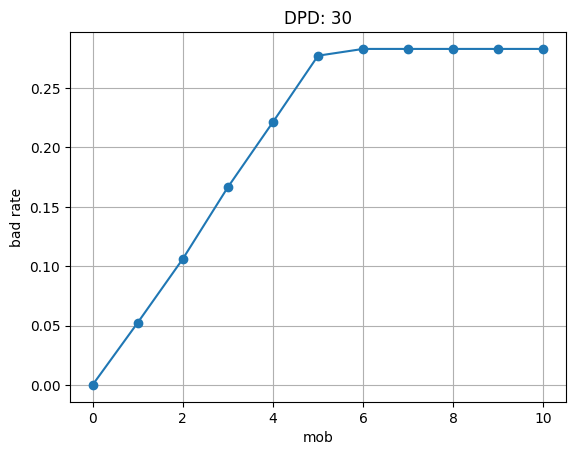

In [47]:
# set dpd label definition
dpd = 30

# Path to the folder containing CSV files
folder_path = silver_loan_daily_directory

# Read all CSV files into a single DataFrame
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)

# filter only completed loans
df = df.filter(col("loan_start_date") < datetime.strptime("2024-01-01", "%Y-%m-%d"))

# create dpd flag if more than dpd
df = df.withColumn("dpd_flag", F.when(col("dpd") >= dpd, 1).otherwise(0))

# actual bads 
actual_bads_df = df.filter(col("installment_num") == 10)

# prepare for analysis
# df = df.filter(col("installment_num") < 10)

# visualise bad rate
pdf = df.toPandas()

# Group by col_A and count occurrences in col_B
grouped = pdf.groupby('mob')['dpd_flag'].mean()

# Sort the index (x-axis) of the grouped DataFrame
grouped = grouped.sort_index()

# Plotting
grouped.plot(kind='line', marker='o')

plt.title('DPD: '+ str(dpd))
plt.xlabel('mob')
plt.ylabel('bad rate')
plt.grid(True)
plt.show()


In [48]:
df.show()

+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+--------+
|             loan_id|Customer_ID|loan_start_date|tenure|installment_num|loan_amt|due_amt|paid_amt|overdue_amt|balance|snapshot_date|mob|installments_missed|first_missed_date|dpd|dpd_flag|
+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+--------+
|CUS_0x1011_2023_1...| CUS_0x1011|     2023-11-01|    10|             10| 10000.0| 1000.0|  1000.0|        0.0|    0.0|   2024-09-01| 10|                  0|             NULL|  0|       0|
|CUS_0x1013_2023_1...| CUS_0x1013|     2023-12-01|    10|              9| 10000.0| 1000.0|  1000.0|        0.0| 1000.0|   2024-09-01|  9|                  0|             NULL|  0|       0|
|CUS_0x1018_2023_1...| CUS_0x1018|     2023-11-01|    1

## EDA on features

In [49]:
folder_path = silver_clickstream_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

silver_click_pdf = df.toPandas()

folder_path = silver_attributes_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

silver_attr_pdf = df.toPandas()

folder_path = silver_financials_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

silver_finanicial_pdf = df.toPandas()

row_count: 215376


row_count: 11974
row_count: 11974


In [50]:
silver_click_pdf.head()

,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,71,243,89,149,202,56,149,207,232,111,...,-17,100,115,68,39,87,-74,240,CUS_0x1037,2024-03-01
1,-60,65,30,-56,25,206,68,157,-36,81,...,169,98,75,268,95,19,151,234,CUS_0x1069,2024-03-01
2,50,76,115,114,-57,136,33,69,175,92,...,30,204,268,181,333,70,190,23,CUS_0x114a,2024-03-01
3,1,245,72,247,212,80,144,138,7,-86,...,-46,159,81,58,340,38,66,-36,CUS_0x1184,2024-03-01
4,8,138,164,147,184,145,134,-72,141,-132,...,62,123,321,-6,213,76,180,113,CUS_0x1297,2024-03-01


In [51]:
silver_attr_pdf.head()

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date,Name_Masked,SSN_Masked
0,CUS_0x10ac,Zhouy,29.0,780-50-4730,Developer,2024-08-01,Z****,XXX-XX-4730
1,CUS_0x10c5,Moony,24.0,041-74-6785,None,2024-08-01,M****,XXX-XX-6785
2,CUS_0x1145,Blenkinsopr,24.0,426-31-9194,Teacher,2024-08-01,B**********,XXX-XX-9194
3,CUS_0x11ac,Liana B.v,26.0,835-92-7751,Journalist,2024-08-01,L********,XXX-XX-7751
4,CUS_0x122c,Papadimasf,48.0,883-73-9594,Entrepreneur,2024-08-01,P*********,XXX-XX-9594


In [52]:
silver_finanicial_pdf.head()

,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,snapshot_date,Payment_Behaviour_Spent,Payment_Behaviour_Payment
0,CUS_0x10ac,16718.644531,1270.220459,7.0,3.0,15.0,4.0,Credit-Builder Loan|Home Equity Loan|Debt Cons...,26,11.0,...,853.409973,31.397339,195,No,50.961937,36.413094,319.647003,2024-08-01,None,None
1,CUS_0x10c5,158623.156250,13180.596680,2.0,7.0,10.0,1.0,Payday Loan,10,5.0,...,1134.829956,41.796799,362,No,91.033905,282.718689,1194.307129,2024-08-01,High,Medium
2,CUS_0x1145,17975.320312,1444.943359,6.0,5.0,32.0,9.0,Student Loan|Payday Loan|Mortgage Loan|Home Eq...,61,25.0,...,1263.099976,25.681799,149,Yes,76.450325,176.776215,181.267792,2024-08-01,Low,Small
3,CUS_0x11ac,69136.539062,5902.378418,3.0,4.0,14.0,0.0,None,14,18.0,...,478.850006,32.103165,209,Yes,0.000000,435.937012,444.300842,2024-08-01,Low,Small
4,CUS_0x122c,36346.128906,3188.844238,8.0,6.0,11.0,3.0,Credit-Builder Loan|Home Equity Loan|Auto Loan,21,15.0,...,1252.459961,28.066704,266,No,89.061554,110.509705,369.313171,2024-08-01,High,Medium


### Check the distribution and the validity of the boundaries.

In [53]:
def plot_features(pdf):
    """
    Plots histograms for numeric columns and countplots for categorical columns
    in the given Pandas DataFrame (pdf).
    Excludes: Customer_ID, Loan_ID, snapshot_date
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Columns to ignore
    exclude_cols = {"Customer_ID", "Loan_ID", "snapshot_date", "Name", "SSN", "Name_Masked", "SSN_Masked", "Hashed_User_ID", "Type_of_Loan"}

    # Separate numeric vs categorical (excluding identifiers)
    numeric_cols = [
        c for c in pdf.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns 
        if c not in exclude_cols
    ]
    categorical_cols = [
        c for c in pdf.select_dtypes(include=["object", "category"]).columns 
        if c not in exclude_cols
    ]

    # --- Numeric histograms ---
    num_cols = len(numeric_cols)
    if num_cols > 0:
        ncols = 4
        nrows = (num_cols + ncols - 1) // ncols
        plt.figure(figsize=(20, nrows * 4))
        for idx, col in enumerate(numeric_cols, 1):
            plt.subplot(nrows, ncols, idx)
            pdf[col].dropna().hist(bins=50)
            plt.title(col)
            plt.xlabel(col)
            plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    # --- Categorical countplots ---
    cat_cols = len(categorical_cols)
    if cat_cols > 0:
        ncols = 4
        nrows = (cat_cols + ncols - 1) // ncols
        plt.figure(figsize=(20, nrows * 4))
        for idx, col in enumerate(categorical_cols, 1):
            plt.subplot(nrows, ncols, idx)
            sns.countplot(x=col, data=pdf)
            plt.title(col)
            plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


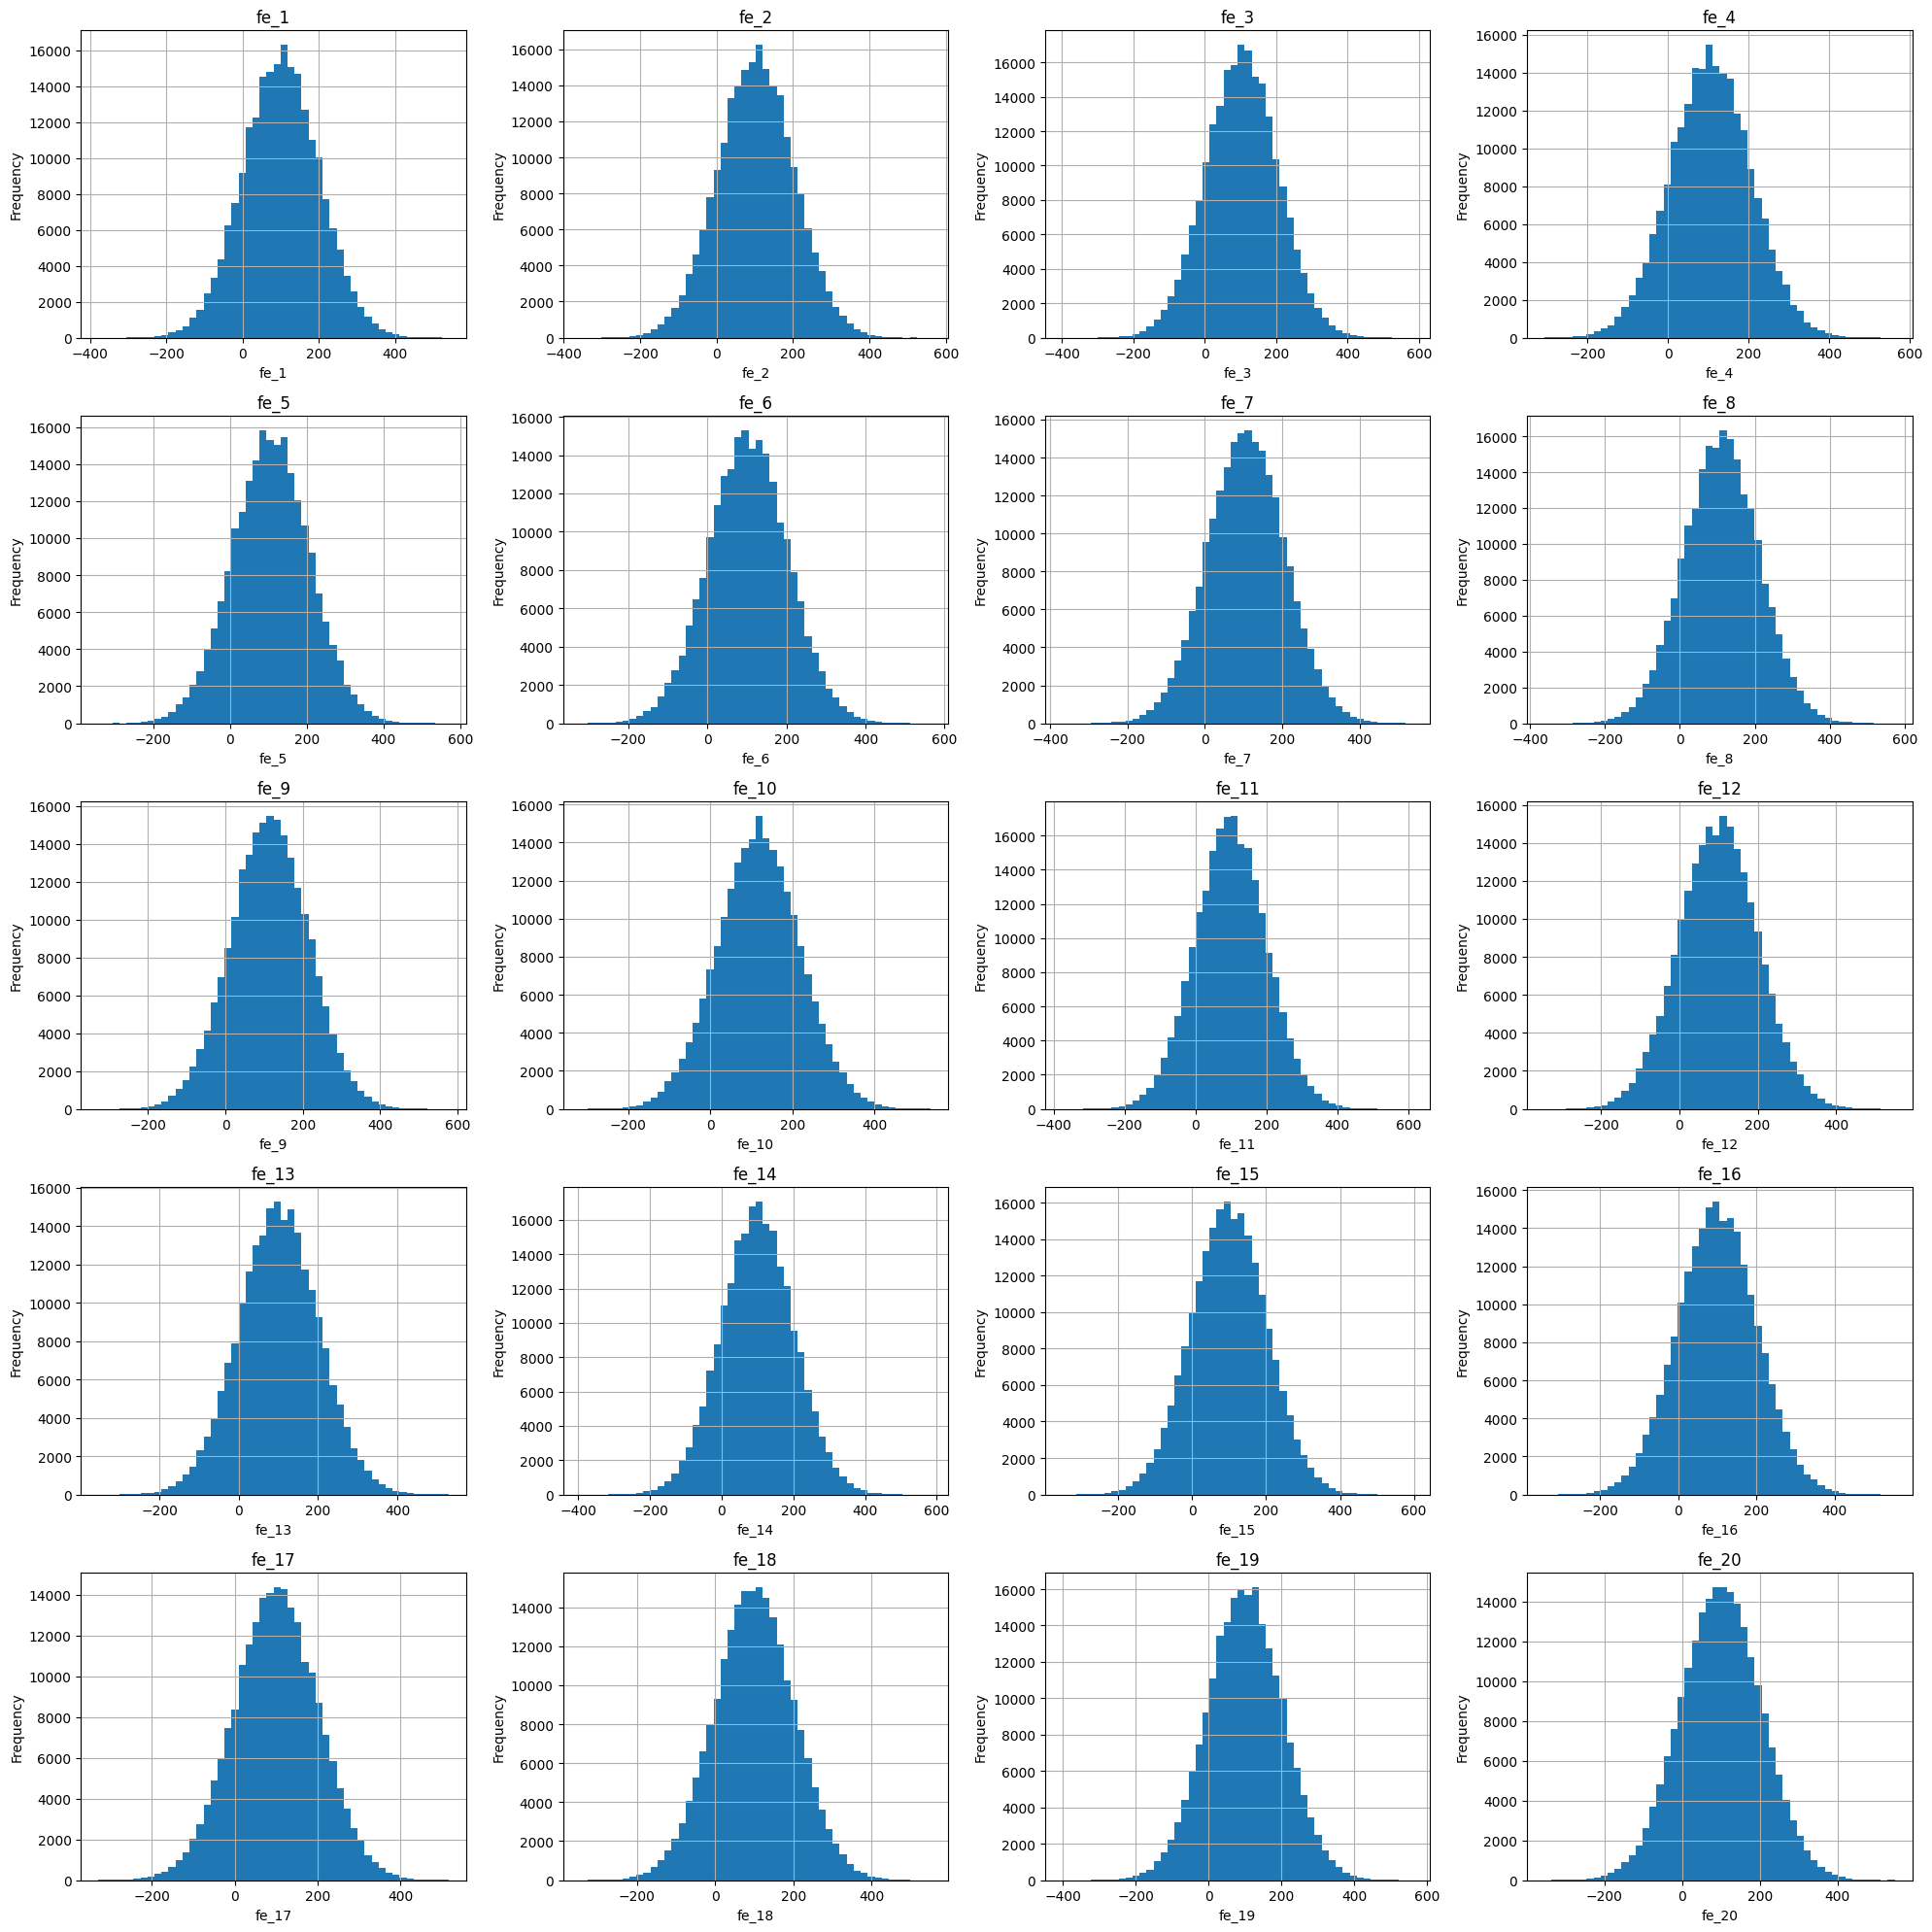

In [54]:
plot_features(silver_click_pdf)

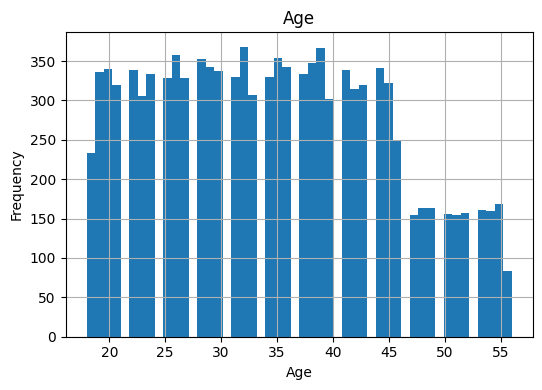

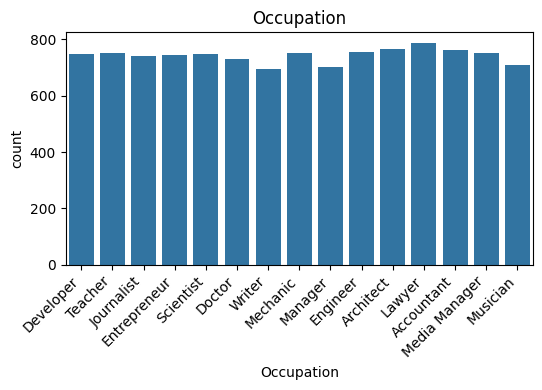

In [55]:
plot_features(silver_attr_pdf)

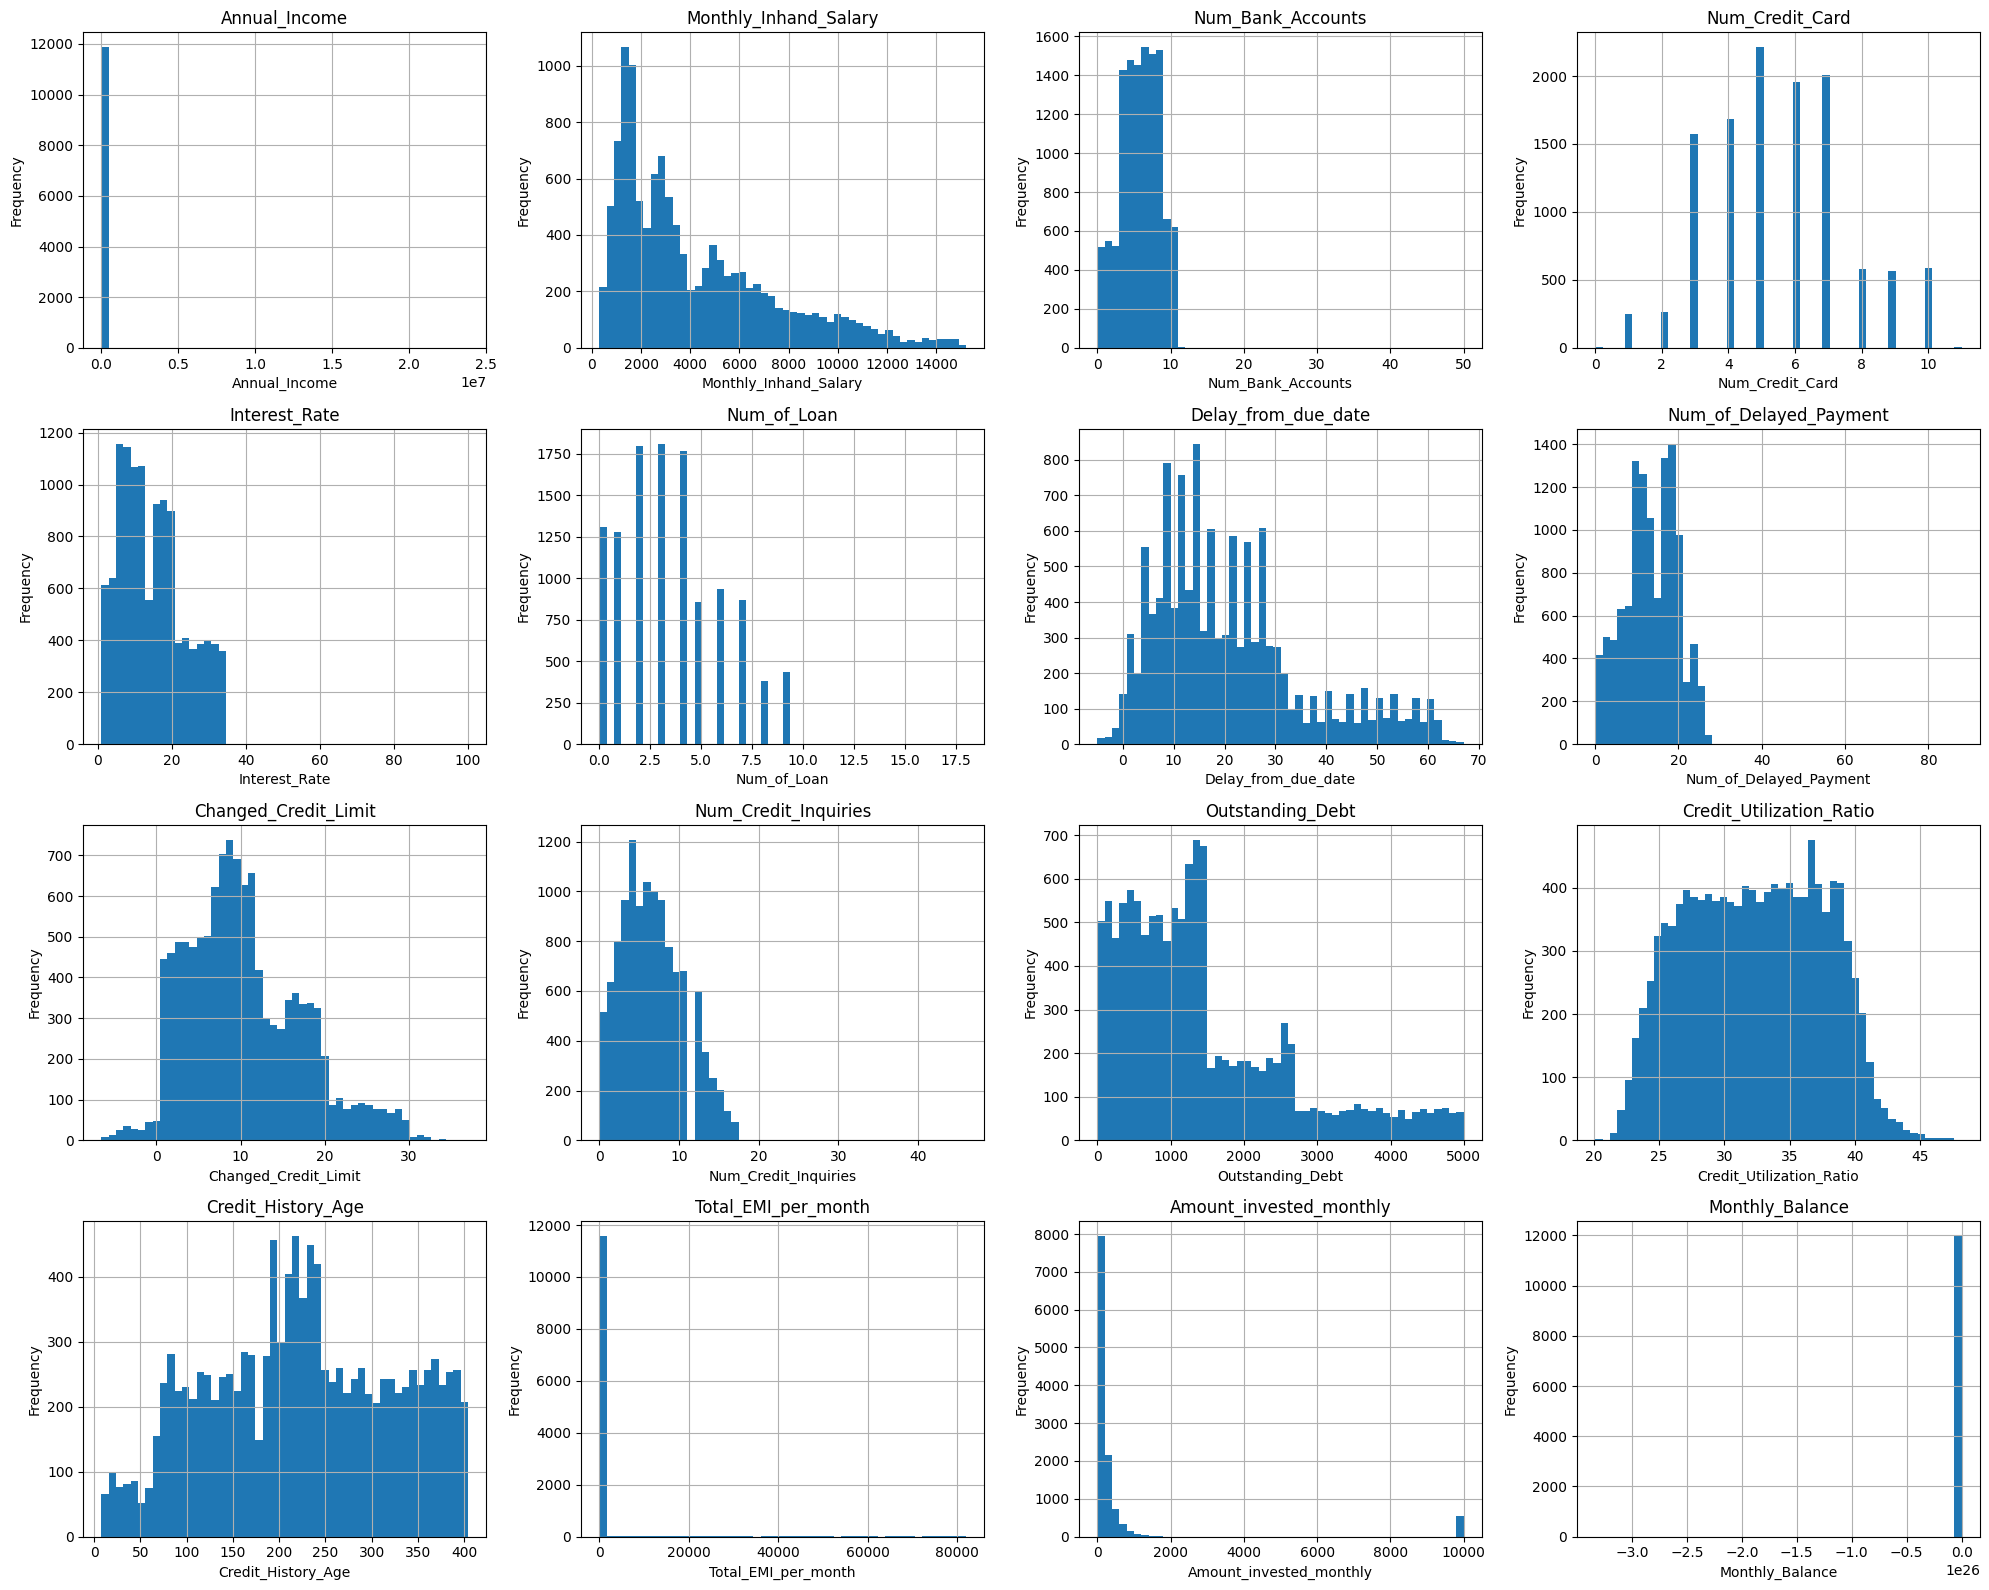

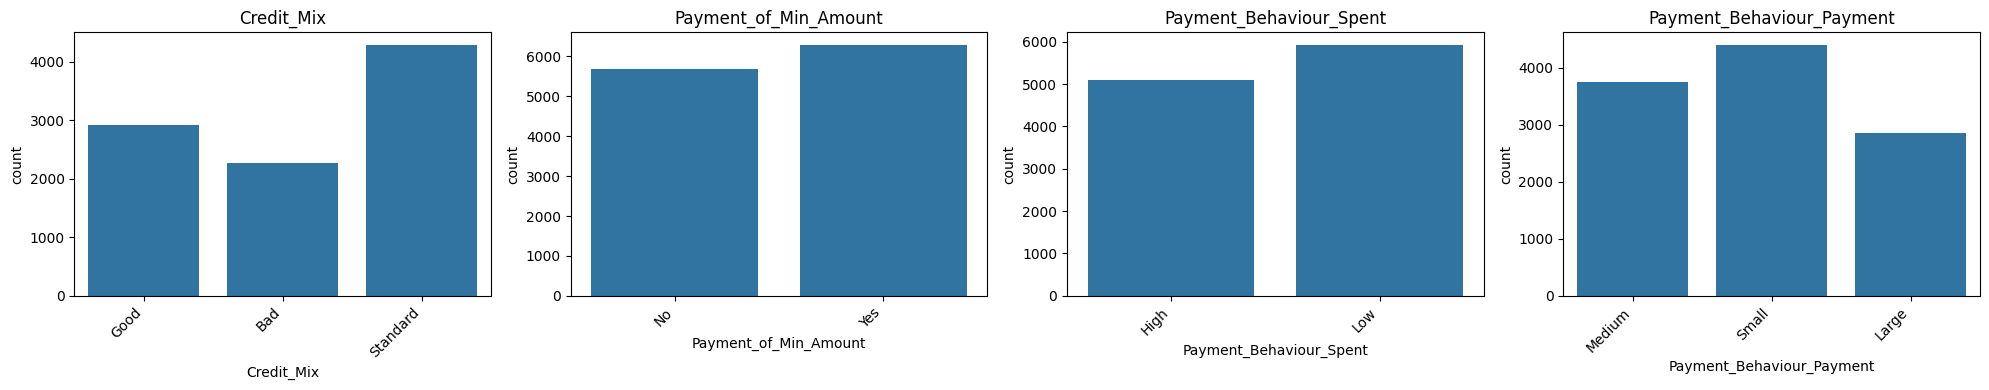

In [56]:
plot_features(silver_finanicial_pdf)

1. Interest Rate > 100% is definitely invalid. (Silver)
2. Number of bank accounts > 50 is suspicious (could be corporate, or data error).
3. Number of credit cards > 20 should be flagged.
4. Number of loans > 20 is highly unusual unless it’s a consolidated dataset or mis-entry.
5. Number of credit inquiries > 50 is highly unusual unless it’s a consolidated dataset or mis-entry.
6. Number of delayed payments (historical) > 100 usually means either aggregated transactions or data quality issue.

In [57]:
silver_click_pdf.duplicated(['Customer_ID']).sum()

np.int64(206402)

In [58]:
silver_attr_pdf.duplicated(['Customer_ID']).sum()

np.int64(0)

In [59]:
silver_finanicial_pdf.duplicated(['Customer_ID']).sum()

np.int64(0)

In [60]:
silver_click_pdf.groupby("Customer_ID").count()

,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_12,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,snapshot_date
Customer_ID,,,,,,,,,,,,,,,,,,,,,
CUS_0x1000,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
CUS_0x100b,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
CUS_0x1011,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
CUS_0x1013,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
CUS_0x1015,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CUS_0xfe5,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
CUS_0xfea,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
CUS_0xff3,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24


## Build gold table for labels

In [61]:
# create gold datalake
gold_label_store_directory = "datamart/gold/label_store/"
gold_feature_store_directory = "datamart/gold/feature_store/"

if not os.path.exists(gold_label_store_directory):
    os.makedirs(gold_label_store_directory)

if not os.path.exists(gold_feature_store_directory):
    os.makedirs(gold_feature_store_directory)

In [62]:
# run gold backfill
for date_str in dates_str_lst:
    utils.data_processing_gold_table.process_labels_gold_table(date_str, silver_loan_daily_directory, silver_clickstream_directory, \
                                                               silver_attributes_directory, silver_financials_directory, gold_feature_store_directory, \
                                                               gold_label_store_directory, spark, dpd = 30, mob = 6)


loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_01_01.parquet row count: 530
saved to: datamart/gold/label_store/gold_label_store_2023_01_01.parquet
Loans: 0


loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_11_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_12_01.parquet', 'datamart/silv

loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_11_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_12_01.parquet', 'datamart/silv

loaded from: ['datamart/silver/users/attributes/silver_users_attributes_2023_01_01.parquet', 'datamart/silver/users/attributes/silver_users_attributes_2023_02_01.parquet', 'datamart/silver/users/attributes/silver_users_attributes_2023_03_01.parquet', 'datamart/silver/users/attributes/silver_users_attributes_2023_04_01.parquet', 'datamart/silver/users/attributes/silver_users_attributes_2023_05_01.parquet', 'datamart/silver/users/attributes/silver_users_attributes_2023_06_01.parquet', 'datamart/silver/users/attributes/silver_users_attributes_2023_07_01.parquet', 'datamart/silver/users/attributes/silver_users_attributes_2023_08_01.parquet', 'datamart/silver/users/attributes/silver_users_attributes_2023_09_01.parquet', 'datamart/silver/users/attributes/silver_users_attributes_2023_10_01.parquet', 'datamart/silver/users/attributes/silver_users_attributes_2023_11_01.parquet', 'datamart/silver/users/attributes/silver_users_attributes_2023_12_01.parquet', 'datamart/silver/users/attributes/silv

saved to: datamart/gold/feature_store/gold_feature_store_2023_07_01.parquet
Clickstream: 530
Attributes: 530
Financials: 530


Features: 530
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_08_01.parquet row count: 4037
saved to: datamart/gold/label_store/gold_label_store_2023_08_01.parquet
Loans: 501
loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10

saved to: datamart/gold/feature_store/gold_feature_store_2023_08_01.parquet
Clickstream: 501
Attributes: 501
Financials: 501


Features: 501
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_09_01.parquet row count: 4491
saved to: datamart/gold/label_store/gold_label_store_2023_09_01.parquet
Loans: 506
loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10

saved to: datamart/gold/feature_store/gold_feature_store_2023_09_01.parquet
Clickstream: 506
Attributes: 506
Financials: 506


Features: 506
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_10_01.parquet row count: 4978
saved to: datamart/gold/label_store/gold_label_store_2023_10_01.parquet
Loans: 510
loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10

saved to: datamart/gold/feature_store/gold_feature_store_2023_10_01.parquet
Clickstream: 510
Attributes: 510
Financials: 510


Features: 510
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_11_01.parquet row count: 5469
saved to: datamart/gold/label_store/gold_label_store_2023_11_01.parquet
Loans: 521
loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10

saved to: datamart/gold/feature_store/gold_feature_store_2023_11_01.parquet
Clickstream: 521
Attributes: 521
Financials: 521


Features: 521
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_12_01.parquet row count: 5428
saved to: datamart/gold/label_store/gold_label_store_2023_12_01.parquet
Loans: 517
loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10

saved to: datamart/gold/feature_store/gold_feature_store_2023_12_01.parquet
Clickstream: 517
Attributes: 517
Financials: 517


Features: 517
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_01_01.parquet row count: 5412
saved to: datamart/gold/label_store/gold_label_store_2024_01_01.parquet
Loans: 471
loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10

saved to: datamart/gold/feature_store/gold_feature_store_2024_01_01.parquet
Clickstream: 471
Attributes: 471
Financials: 471


Features: 471
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_02_01.parquet row count: 5424
saved to: datamart/gold/label_store/gold_label_store_2024_02_01.parquet
Loans: 481
loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10

saved to: datamart/gold/feature_store/gold_feature_store_2024_02_01.parquet
Clickstream: 481
Attributes: 481
Financials: 481


Features: 481
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_03_01.parquet row count: 5425
saved to: datamart/gold/label_store/gold_label_store_2024_03_01.parquet
Loans: 454
loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10

saved to: datamart/gold/feature_store/gold_feature_store_2024_03_01.parquet
Clickstream: 454
Attributes: 454
Financials: 454


Features: 454
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_04_01.parquet row count: 5417
saved to: datamart/gold/label_store/gold_label_store_2024_04_01.parquet
Loans: 487
loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10

saved to: datamart/gold/feature_store/gold_feature_store_2024_04_01.parquet
Clickstream: 487
Attributes: 487
Financials: 487


Features: 487
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_05_01.parquet row count: 5391
saved to: datamart/gold/label_store/gold_label_store_2024_05_01.parquet
Loans: 491
loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10

saved to: datamart/gold/feature_store/gold_feature_store_2024_05_01.parquet
Clickstream: 491
Attributes: 491
Financials: 491


Features: 491
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_06_01.parquet row count: 5418
saved to: datamart/gold/label_store/gold_label_store_2024_06_01.parquet
Loans: 489
loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10

saved to: datamart/gold/feature_store/gold_feature_store_2024_06_01.parquet
Clickstream: 489
Attributes: 489
Financials: 489


Features: 489
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_07_01.parquet row count: 5442
saved to: datamart/gold/label_store/gold_label_store_2024_07_01.parquet
Loans: 485
loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10

saved to: datamart/gold/feature_store/gold_feature_store_2024_07_01.parquet
Clickstream: 485
Attributes: 485
Financials: 485


Features: 485
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_08_01.parquet row count: 5531
saved to: datamart/gold/label_store/gold_label_store_2024_08_01.parquet
Loans: 518
loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10

saved to: datamart/gold/feature_store/gold_feature_store_2024_08_01.parquet
Clickstream: 518
Attributes: 518
Financials: 518


Features: 518
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_09_01.parquet row count: 5537
saved to: datamart/gold/label_store/gold_label_store_2024_09_01.parquet
Loans: 511
loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10

saved to: datamart/gold/feature_store/gold_feature_store_2024_09_01.parquet
Clickstream: 511
Attributes: 511
Financials: 511


Features: 511
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_10_01.parquet row count: 5502
saved to: datamart/gold/label_store/gold_label_store_2024_10_01.parquet
Loans: 513
loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10

saved to: datamart/gold/feature_store/gold_feature_store_2024_10_01.parquet
Clickstream: 513
Attributes: 513
Financials: 513


Features: 513
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_11_01.parquet row count: 5501
saved to: datamart/gold/label_store/gold_label_store_2024_11_01.parquet
Loans: 491
loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10

saved to: datamart/gold/feature_store/gold_feature_store_2024_11_01.parquet
Clickstream: 491
Attributes: 491
Financials: 491


Features: 491
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_12_01.parquet row count: 5531
saved to: datamart/gold/label_store/gold_label_store_2024_12_01.parquet
Loans: 498
loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10

saved to: datamart/gold/feature_store/gold_feature_store_2024_12_01.parquet
Clickstream: 498
Attributes: 498
Financials: 498


Features: 498


In [63]:
loans_df, feature_df = utils.data_processing_gold_table.process_labels_gold_table(date_str, silver_loan_daily_directory, silver_clickstream_directory, \
                                                                silver_attributes_directory, silver_financials_directory, gold_feature_store_directory, \
                                                                gold_label_store_directory, spark, dpd = 30, mob = 6)

loans_df.dtypes

loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_12_01.parquet row count: 5531
saved to: datamart/gold/label_store/gold_label_store_2024_12_01.parquet
Loans: 498
loaded from: ['datamart/silver/users/clickstream/silver_users_clickstream_2023_01_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_02_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_03_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_04_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_05_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_06_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_07_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_08_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_09_01.parquet', 'datamart/silver/users/clickstream/silver_users_clickstream_2023_10_01.parquet', 

saved to: datamart/gold/feature_store/gold_feature_store_2024_12_01.parquet
Clickstream: 498
Attributes: 498
Financials: 498


Features: 498


[('loan_id', 'string'),
 ('Customer_ID', 'string'),
 ('label', 'int'),
 ('label_def', 'string'),
 ('snapshot_date', 'date')]

In [64]:
loans_df.show()

+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x10dd_2024_0...| CUS_0x10dd|    0|30dpd_6mob|   2024-12-01|
|CUS_0x1109_2024_0...| CUS_0x1109|    1|30dpd_6mob|   2024-12-01|
|CUS_0x1286_2024_0...| CUS_0x1286|    0|30dpd_6mob|   2024-12-01|
|CUS_0x12a8_2024_0...| CUS_0x12a8|    0|30dpd_6mob|   2024-12-01|
|CUS_0x1309_2024_0...| CUS_0x1309|    0|30dpd_6mob|   2024-12-01|
|CUS_0x13f8_2024_0...| CUS_0x13f8|    0|30dpd_6mob|   2024-12-01|
|CUS_0x1472_2024_0...| CUS_0x1472|    0|30dpd_6mob|   2024-12-01|
|CUS_0x15a3_2024_0...| CUS_0x15a3|    0|30dpd_6mob|   2024-12-01|
|CUS_0x15f4_2024_0...| CUS_0x15f4|    0|30dpd_6mob|   2024-12-01|
|CUS_0x15f8_2024_0...| CUS_0x15f8|    0|30dpd_6mob|   2024-12-01|
|CUS_0x1640_2024_0...| CUS_0x1640|    1|30dpd_6mob|   2024-12-01|
|CUS_0x1699_2024_0...| CUS_0x1699|    1|30dpd_6mob|   2024-12-01|
|CUS_0x16b

## inspect feature store

In [65]:
feature_df.show()

+-----------+-------------------+-------+------------+------------------------+-------------+---------------------+-----------------+---------------+-----------+--------------------+-------------+-------------------+----------------------+--------------------+----------------+------------------------+------------------+-------------------+-----------------------+---------------+------------------------+--------------+-------------------------+---------------------------+-----------------------------+--------------------+--------------------+------------------+-----------------------+------------------------+---------------------+--------------------+---------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|Customer_ID|label_snapshot_date|Age_bin|  Occupation|attributes_snapshot_date|Annual_Income|Monthly_Inhand_

In [66]:
feature_df.printSchema()

root
 |-- Customer_ID: string (nullable = true)
 |-- label_snapshot_date: date (nullable = true)
 |-- Age_bin: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- attributes_snapshot_date: date (nullable = true)
 |-- Annual_Income: float (nullable = true)
 |-- Monthly_Inhand_Salary: float (nullable = true)
 |-- Num_Bank_Accounts: integer (nullable = true)
 |-- Num_Credit_Card: integer (nullable = true)
 |-- Num_of_Loan: integer (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Interest_Rate: float (nullable = true)
 |-- Delay_from_due_date: integer (nullable = true)
 |-- Num_of_Delayed_Payment: integer (nullable = true)
 |-- Num_Credit_Inquiries: integer (nullable = true)
 |-- Outstanding_Debt: float (nullable = true)
 |-- Credit_Utilization_Ratio: float (nullable = true)
 |-- Credit_History_Age: integer (nullable = true)
 |-- Total_EMI_per_month: float (nullable = true)
 |-- Amount_invested_monthly: float (nullable = true)
 |-- Monthly_Balance: flo

In [67]:
folder_path = gold_feature_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
gold_feature_df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",gold_feature_df.count())

gold_feature_df.show()

row_count: 8974
+-----------+-------------------+-------+------------+------------------------+-------------+---------------------+-----------------+---------------+-----------+--------------------+-------------+-------------------+----------------------+--------------------+----------------+------------------------+------------------+-------------------+-----------------------+---------------+------------------------+--------------+-------------------------+---------------------------+-----------------------------+--------------------+--------------------+------------------+-----------------------+------------------------+---------------------+--------------------+---------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|Customer_ID|label_snapshot_date|Age_bin|  Occupation|attributes_snapshot_date|Annual_Income

In [68]:
gold_feature_pdf = gold_feature_df.toPandas()

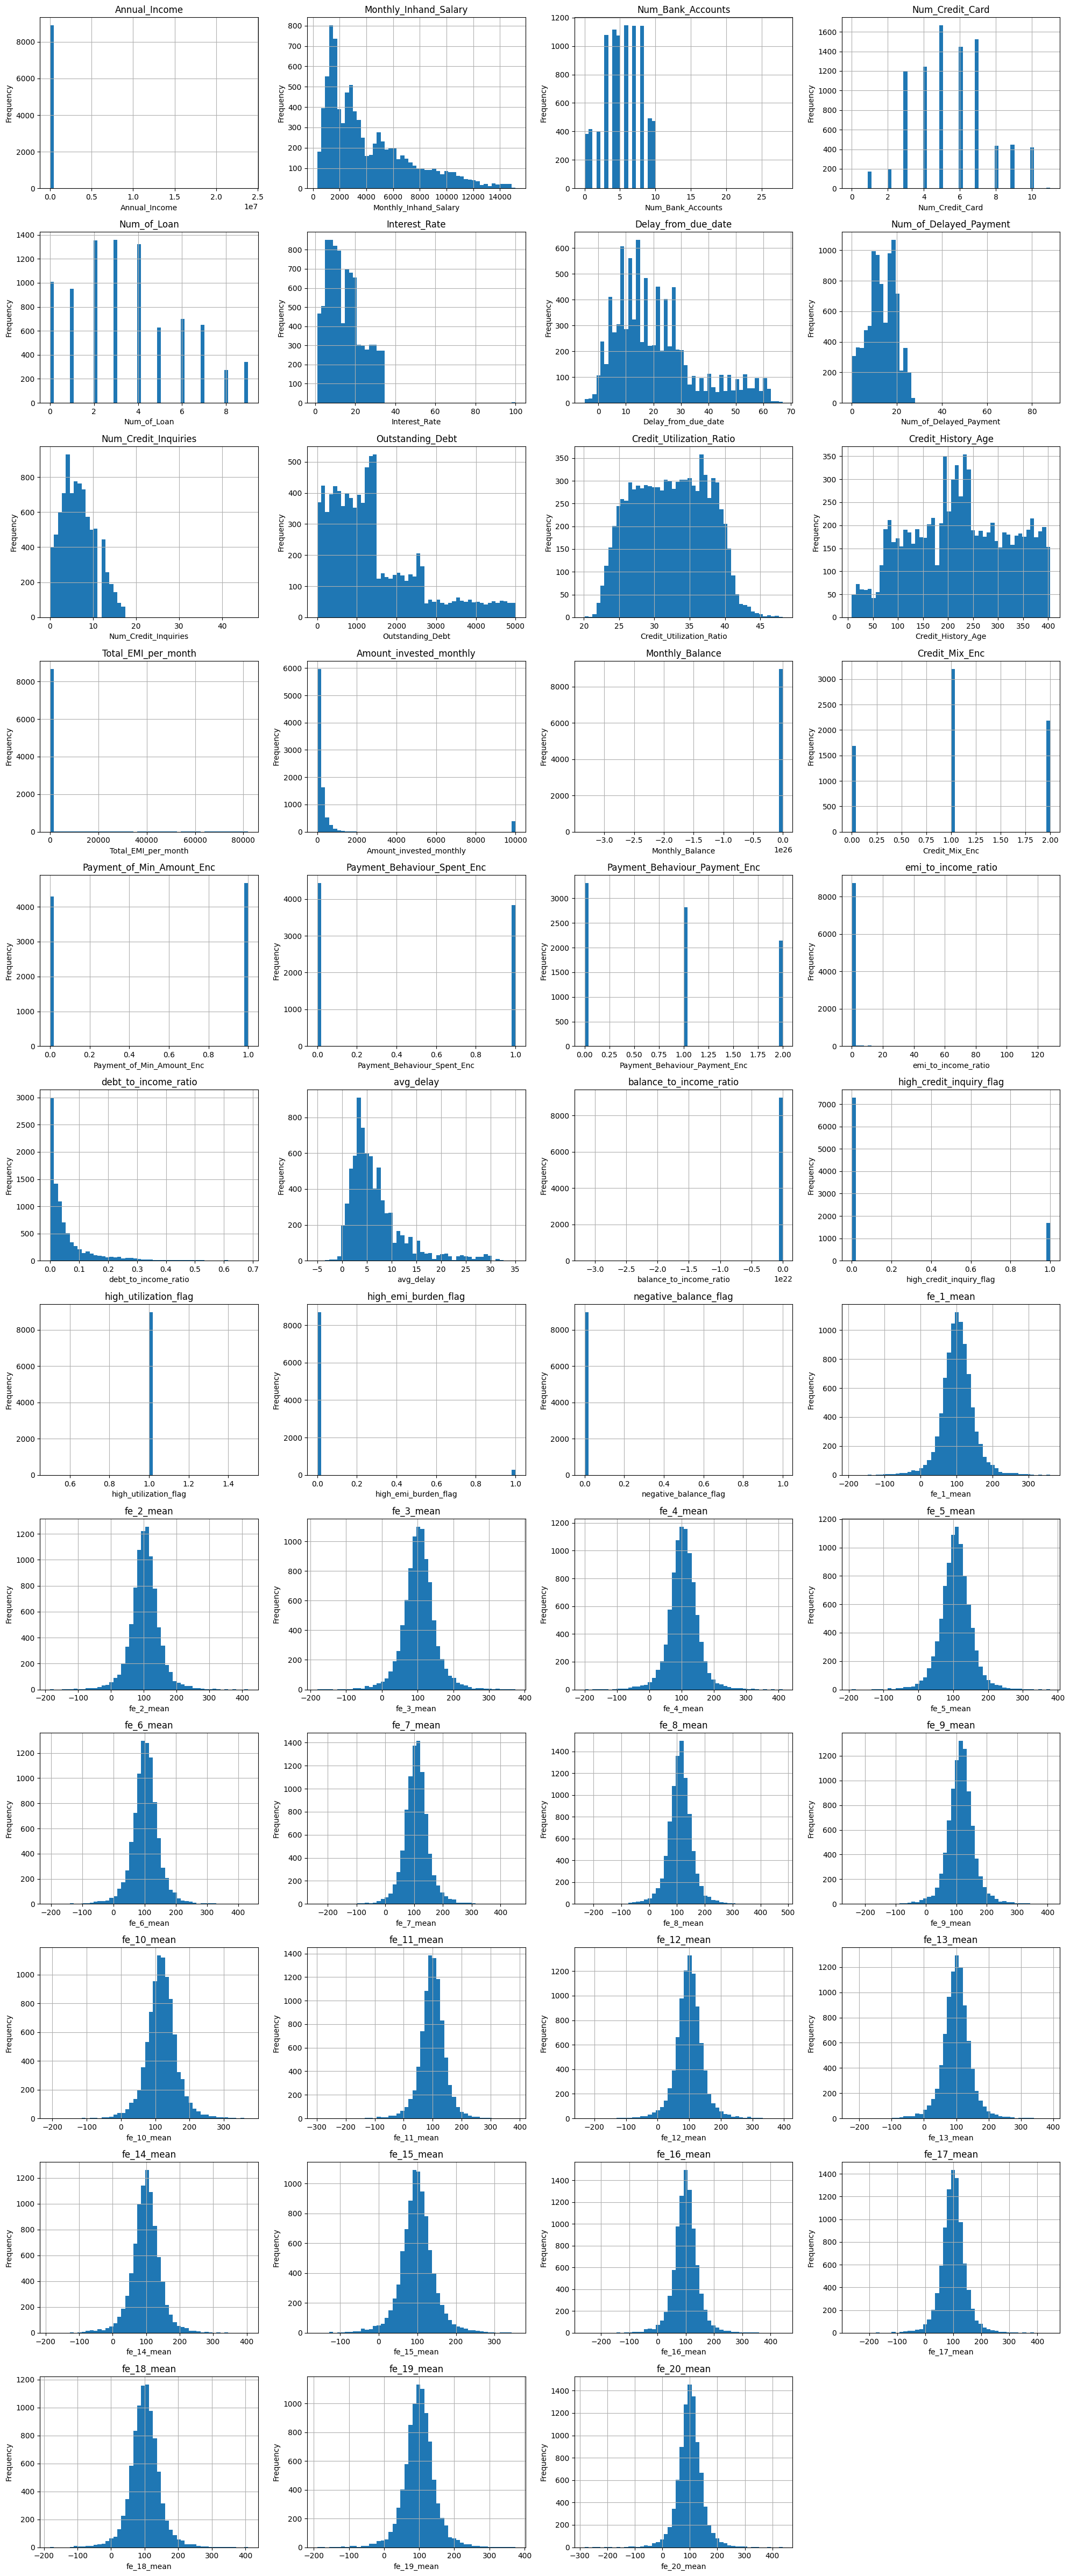

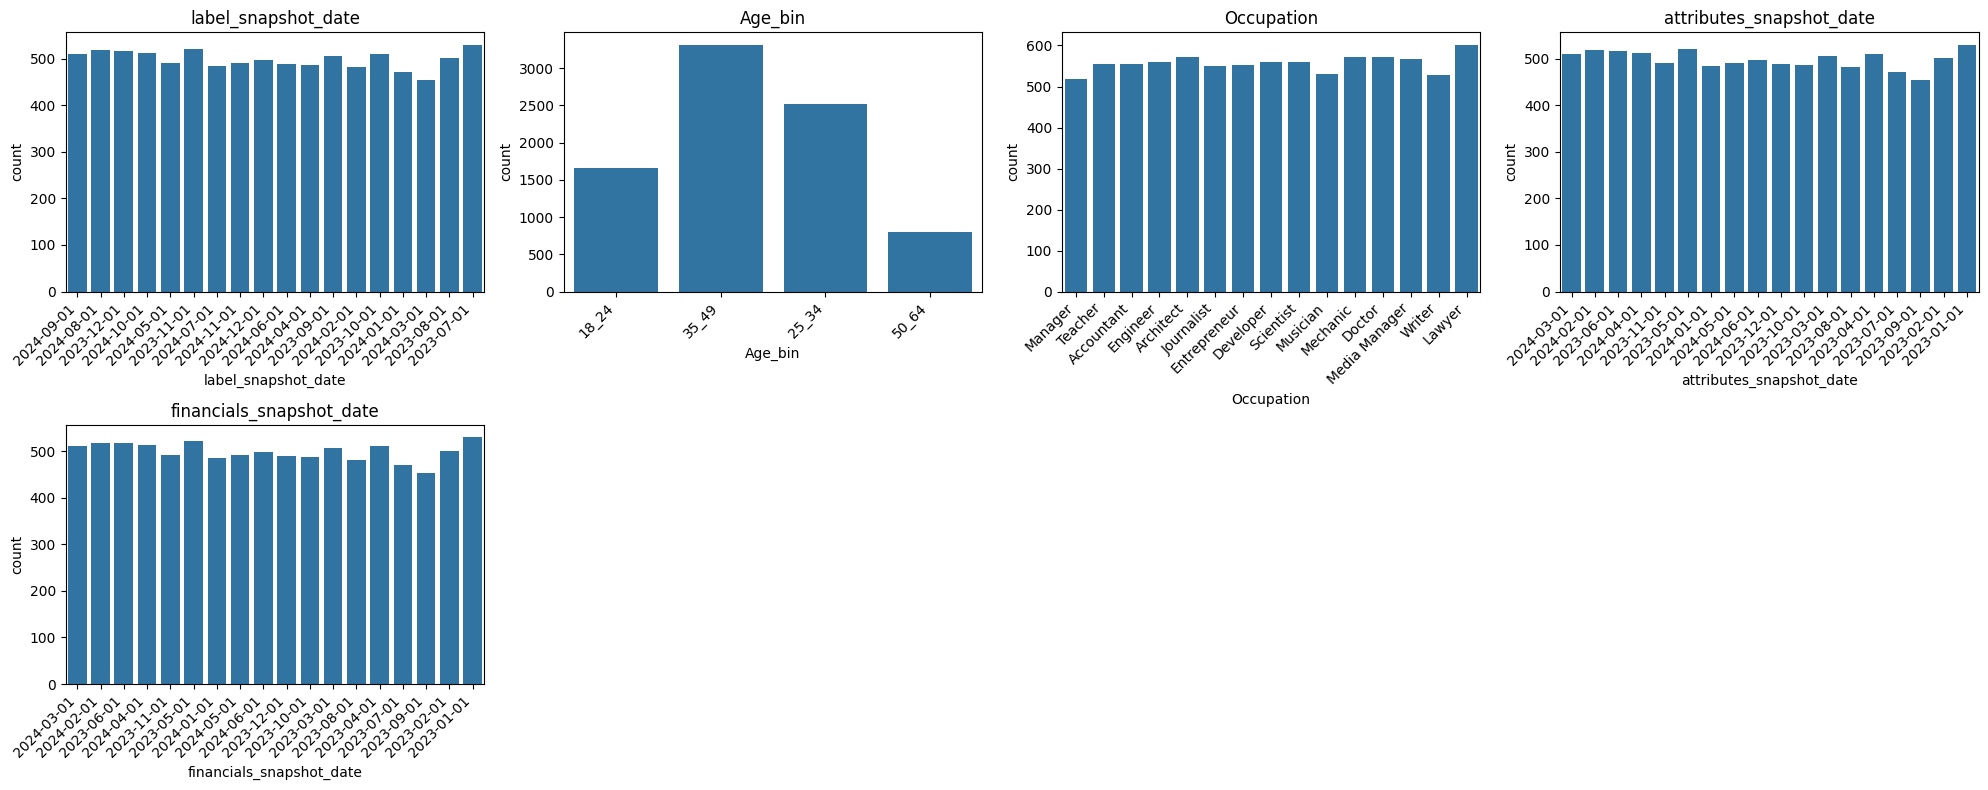

In [69]:
plot_features(gold_feature_pdf)

## inspect label store

In [70]:
folder_path = gold_label_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
gold_loans_df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",gold_loans_df.count())

gold_loans_df.show()

row_count: 8974
+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x1037_2023_0...| CUS_0x1037|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1069_2023_0...| CUS_0x1069|    0|30dpd_6mob|   2023-07-01|
|CUS_0x114a_2023_0...| CUS_0x114a|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1184_2023_0...| CUS_0x1184|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1297_2023_0...| CUS_0x1297|    1|30dpd_6mob|   2023-07-01|
|CUS_0x12fb_2023_0...| CUS_0x12fb|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1325_2023_0...| CUS_0x1325|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1341_2023_0...| CUS_0x1341|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1375_2023_0...| CUS_0x1375|    1|30dpd_6mob|   2023-07-01|
|CUS_0x13a8_2023_0...| CUS_0x13a8|    0|30dpd_6mob|   2023-07-01|
|CUS_0x13ef_2023_0...| CUS_0x13ef|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1440_2023_0...| CUS_0x1440|    0|30dpd_6mob|   2023-0

In [71]:
gold_loans_df.printSchema()

root
 |-- loan_id: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_def: string (nullable = true)
 |-- snapshot_date: date (nullable = true)



## Observe how's the training features obtained before the label snapshot date to prevent data leakage (peek from the future)

In [72]:
folder_path = silver_clickstream_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
silver_click_df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",silver_click_df.count())

folder_path = silver_attributes_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
silver_attr_df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",silver_attr_df.count())

folder_path = silver_financials_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
silver_fin_df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",silver_fin_df.count())

row_count: 215376
row_count: 11974
row_count: 11974


In [73]:
gold_cust_id_df = gold_loans_df[["Customer_ID", "snapshot_date"]]

In [74]:
gold_cust_id_df

DataFrame[Customer_ID: string, snapshot_date: date]

### Clickstream

In [75]:
feature_cols = [F.col(f"scd.fe_{i}") for i in range(1, 21)]

merged_silver_click_df = (
    silver_click_df.alias("scd")
    .join(gold_cust_id_df.alias("gcd"), on="Customer_ID", how="inner")
    .filter(F.col("scd.snapshot_date") < F.add_months(F.col("gcd.snapshot_date"), -5))
    .select(
        "scd.Customer_ID",
        *feature_cols,
        F.col("scd.snapshot_date").alias("scd_snapshot_date"),
        F.col("gcd.snapshot_date").alias("gcd_snapshot_date")
    )
)

In [76]:
merged_silver_click_df.count()

84908

#### One customer has more than one clickstream row

In [77]:
merged_silver_click_df[merged_silver_click_df["Customer_ID"] == "CUS_0x100b"].orderBy("scd_snapshot_date").show()

[Stage 2581:>                                                     (0 + 12) / 12]

+-----------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----------------+-----------------+
|Customer_ID|fe_1|fe_2|fe_3|fe_4|fe_5|fe_6|fe_7|fe_8|fe_9|fe_10|fe_11|fe_12|fe_13|fe_14|fe_15|fe_16|fe_17|fe_18|fe_19|fe_20|scd_snapshot_date|gcd_snapshot_date|
+-----------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----------------+-----------------+
| CUS_0x100b| -46| 178| 115| 188|-116| 228| 103|-174|  81|   43|  237|  125|  195|  323|  -37|  180| -128|  139|  162|   76|       2023-01-01|       2024-09-01|
| CUS_0x100b| 274|  98| 233| 114|   9| 228| 132| -70| 201|   71|  270|   42|  -12|  -42|  334|   36|   -4|   36| -207|  -17|       2023-02-01|       2024-09-01|
| CUS_0x100b| -17|  29| 167|  99|  97| 188| 123| 172| 135|    7|  242|   47|  118|   59|  135|   23|  122|  102|  213|  349|       2023-03-01|       2024-09-01|
| CUS_0x100b|  75| -41| -88| 125| 

#### Take the average as the clickstream features for each customer

In [78]:
df_mean = merged_silver_click_df.groupby("Customer_ID").mean()

# Round all numeric columns to 2 decimals
df_rounded = df_mean.select(
    *[
        F.round(F.col(c), 2).alias(c) if c != "Customer_ID" else F.col(c)
        for c in df_mean.columns
    ]
)

df_rounded.show()

[Stage 2583:====================================>                  (8 + 4) / 12]

+-----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|Customer_ID|avg(fe_1)|avg(fe_2)|avg(fe_3)|avg(fe_4)|avg(fe_5)|avg(fe_6)|avg(fe_7)|avg(fe_8)|avg(fe_9)|avg(fe_10)|avg(fe_11)|avg(fe_12)|avg(fe_13)|avg(fe_14)|avg(fe_15)|avg(fe_16)|avg(fe_17)|avg(fe_18)|avg(fe_19)|avg(fe_20)|
+-----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| CUS_0x1ed5|   110.31|   129.88|   126.75|   117.25|   119.13|    62.75|    99.13|   115.31|    91.56|    107.31|    132.13|     66.06|    133.44|     93.44|    104.75|    102.75|     60.94|    116.75|     94.44|    123.44|
| CUS_0x5479|    64.69|   107.31|    96.75|    119.0|    95.19|    54.75|    119.5|   109.31|   119.

### Attributes

In [79]:
merged_silver_attr_df = (
    silver_attr_df.alias("sad")
    .join(gold_cust_id_df.alias("gcd"), on="Customer_ID", how="inner")
    .filter(F.col("sad.snapshot_date") < F.add_months(F.col("gcd.snapshot_date"), -5))
    .select(
        F.col("sad.Customer_ID"),
        F.col("sad.Age"),
        F.col("sad.Occupation"),
        F.col("sad.snapshot_date").alias("sad_snapshot_date"),
        F.col("gcd.snapshot_date").alias("gcd_snapshot_date")
    )
)

merged_silver_attr_df = merged_silver_attr_df.withColumn(
    "Age_bin",
    F.when(F.col("Age") < 18, "under_18")
     .when((F.col("Age") >= 18) & (F.col("Age") < 25), "18_24")
     .when((F.col("Age") >= 25) & (F.col("Age") < 35), "25_34")
     .when((F.col("Age") >= 35) & (F.col("Age") < 50), "35_49")
     .when((F.col("Age") >= 50) & (F.col("Age") < 65), "50_64")
     .when((F.col("Age") >= 65), "65_plus")
     .otherwise(None)
)

In [80]:
merged_silver_attr_df.count()

8974

In [81]:
merged_silver_attr_df.show()

+-----------+----+-------------+-----------------+-----------------+-------+
|Customer_ID| Age|   Occupation|sad_snapshot_date|gcd_snapshot_date|Age_bin|
+-----------+----+-------------+-----------------+-----------------+-------+
| CUS_0x1000|  18|       Lawyer|       2023-05-01|       2023-11-01|  18_24|
| CUS_0x108a|  38|   Journalist|       2023-05-01|       2023-11-01|  35_49|
| CUS_0x10f9|  54|         NULL|       2023-05-01|       2023-11-01|  50_64|
| CUS_0x1119|  36| Entrepreneur|       2023-05-01|       2023-11-01|  35_49|
| CUS_0x1192|NULL|Media Manager|       2023-05-01|       2023-11-01|   NULL|
| CUS_0x11b1|  28|         NULL|       2023-05-01|       2023-11-01|  25_34|
| CUS_0x12a7|  37|Media Manager|       2023-05-01|       2023-11-01|  35_49|
| CUS_0x12a9|  44|Media Manager|       2023-05-01|       2023-11-01|  35_49|
| CUS_0x1340|  42|    Architect|       2023-05-01|       2023-11-01|  35_49|
| CUS_0x13d1|  22|     Musician|       2023-05-01|       2023-11-01|  18_24|

### Financials

In [82]:
merged_silver_fin_df = (
    silver_fin_df.alias("sfd")
    .join(gold_cust_id_df.alias("gcd"), on="Customer_ID", how="inner")
    .filter(F.col("sfd.snapshot_date") < F.add_months(F.col("gcd.snapshot_date"), -5))
    .select(
        F.col("sfd.Customer_ID"),
        F.col("sfd.Annual_Income"),
        F.col("sfd.Monthly_Inhand_Salary"),
        F.col("sfd.Num_Bank_Accounts"),
        F.col("sfd.Num_Credit_Card"),
        F.col("sfd.Interest_Rate"),
        F.col("sfd.Num_of_Loan"),
        F.col("sfd.Type_of_Loan"),
        F.col("sfd.Delay_from_due_date"),
        F.col("sfd.Num_of_Delayed_Payment"),
        F.col("sfd.Changed_Credit_Limit"),
        F.col("sfd.Num_Credit_Inquiries"),
        F.col("sfd.Credit_Mix"),
        F.col("sfd.Outstanding_Debt"),
        F.col("sfd.Credit_Utilization_Ratio"),
        F.col("sfd.Credit_History_Age"),
        F.col("sfd.Payment_of_Min_Amount"),
        F.col("sfd.Total_EMI_per_month"),
        F.col("sfd.Amount_invested_monthly"),
        F.col("sfd.Monthly_Balance"),
        F.col("sfd.Payment_Behaviour_Spent"),
        F.col("sfd.Payment_Behaviour_Payment"),
        F.col("sfd.snapshot_date").alias("sfd_snapshot_date"),
        F.col("gcd.snapshot_date").alias("gcd_snapshot_date")
    )
)

In [83]:
merged_silver_fin_df.show()

+-----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+---------------+-----------------------+-------------------------+-----------------+-----------------+
|Customer_ID|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|Monthly_Balance|Payment_Behaviour_Spent|Payment_Behaviour_Payment|sfd_snapshot_date|gcd_snapshot_date|
+-----------+-------------+---------------------+-----------------+---------------+-----

In [84]:
merged_silver_fin_df.count()

8974